# Run a Regression For All Predictors Vs. Precipitation

In [1]:
import os
import glob  
import sys
from multiprocessing import Pool 
import time 
import numpy as np
import rasterio
import multiprocessing
import matplotlib.pyplot as plt
import xarray as xr
import dask
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cartopy.feature as cfeature
from scipy.stats import pearsonr
import seaborn as sns
from shapely.geometry import Point, Polygon
import geopandas as gpd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

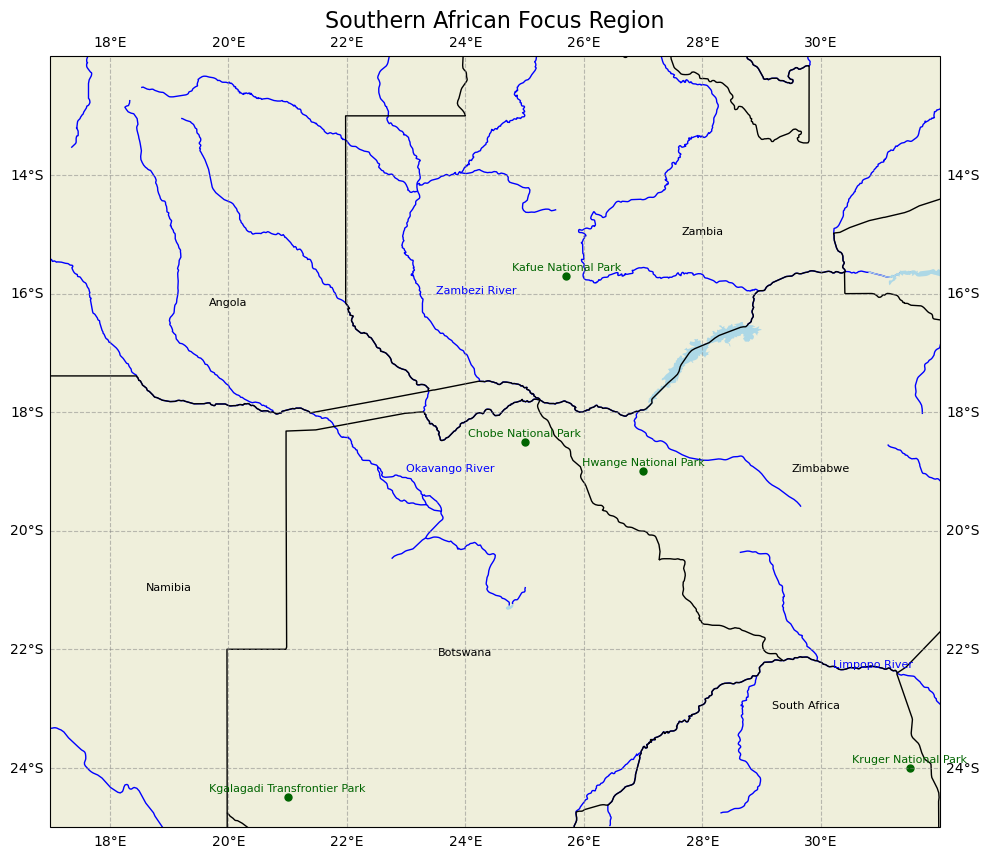

In [2]:
# Define lat-lon boundary
lat_min, lat_max = -25, -12
lon_min, lon_max = 17, 32

# List of national parks in the region (examples, you can add more if necessary)
national_parks = {
    "Kafue National Park": (-15.7, 25.7),
    "Kruger National Park": (-24.0, 31.5),
    "Hwange National Park": (-19.0, 27.0),
    "Chobe National Park": (-18.5, 25.0),
    "Kgalagadi Transfrontier Park": (-24.5, 21.0),
}

# Rivers in the region 
rivers = {
    "Zambezi River": (-16.0, 23.5),
    "Limpopo River": (-22.3, 30.2),
    "Okavango River": (-19.0, 23.0),
}

countries = {
    "Angola": (-16.2, 20.0),
    "Namibia": (-21.0, 19.0),
    "South Africa": (-23.0, 29.75),
    "Zambia": (-15.0, 28.0),
    "Zimbabwe": (-19.0, 30.0),
    "Botswana": (-22.1, 24.0),
}

# Create the map with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add rivers 
ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=1)

# Add natural features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

# Plot national parks as points
for park, (lat, lon) in national_parks.items():
    ax.plot(lon, lat, marker='o', color='darkgreen', markersize=5, transform=ccrs.PlateCarree())
    ax.text(lon, lat+0.1, park, fontsize=8, ha='center', color='darkgreen', transform=ccrs.PlateCarree())

# Label rivers within the region
for river, (lat, lon) in rivers.items():
    ax.text(lon, lat, river, fontsize=8, ha='left', color='blue', transform=ccrs.PlateCarree())

for country, (lat, lon) in countries.items():
    ax.text(lon, lat, country, fontsize=8, ha='center', color='black', transform=ccrs.PlateCarree())
    
# Gridlines and formatting
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Title and display the map
ax.set_title('Southern African Focus Region', fontsize=16)
plt.tight_layout()
plt.show()

In [3]:
#SST data
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')

mon_sst_anom = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_sst_month_anom.nc')

mon_sst_anom =  mon_sst_anom.sortby('valid_time')

mon_sst_anom = mon_sst_anom.rename({'valid_time': 'date'})

new_dates = pd.to_datetime(mon_sst_anom.coords['date']).to_period('M').start_time
mon_sst_anom = mon_sst_anom.assign_coords(date=new_dates)

In [4]:
#Precipitation data
mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')

lat_min, lat_max = -25, -12  
lon_min, lon_max = 17, 32

mon_precip_zambia = mon_precip_sa.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
mon_precip_zambia_mean = mon_precip_zambia.mean(dim=('latitude', 'longitude'))

o_f_precip_zambia = mon_precip_zambia.sel(date=(mon_precip_zambia['date.month'] >= 10) | (mon_precip_zambia['date.month'] <= 2))

o_f_precip_zambia_mean = mon_precip_zambia_mean.sel(date=(mon_precip_zambia_mean['date.month'] >= 10) | (mon_precip_zambia_mean['date.month'] <= 2))
o_f_precip_zambia_mean

<xarray.Dataset> Size: 11kB
Dimensions:  (date: 405)
Coordinates:
    number   int64 8B ...
  * date     (date) datetime64[ns] 3kB 1940-01-01 1940-02-01 ... 2020-12-01
    expver   (date) <U4 6kB ...
Data variables:
    tp       (date) float32 2kB 0.006553 0.003822 ... 0.003284 0.007111

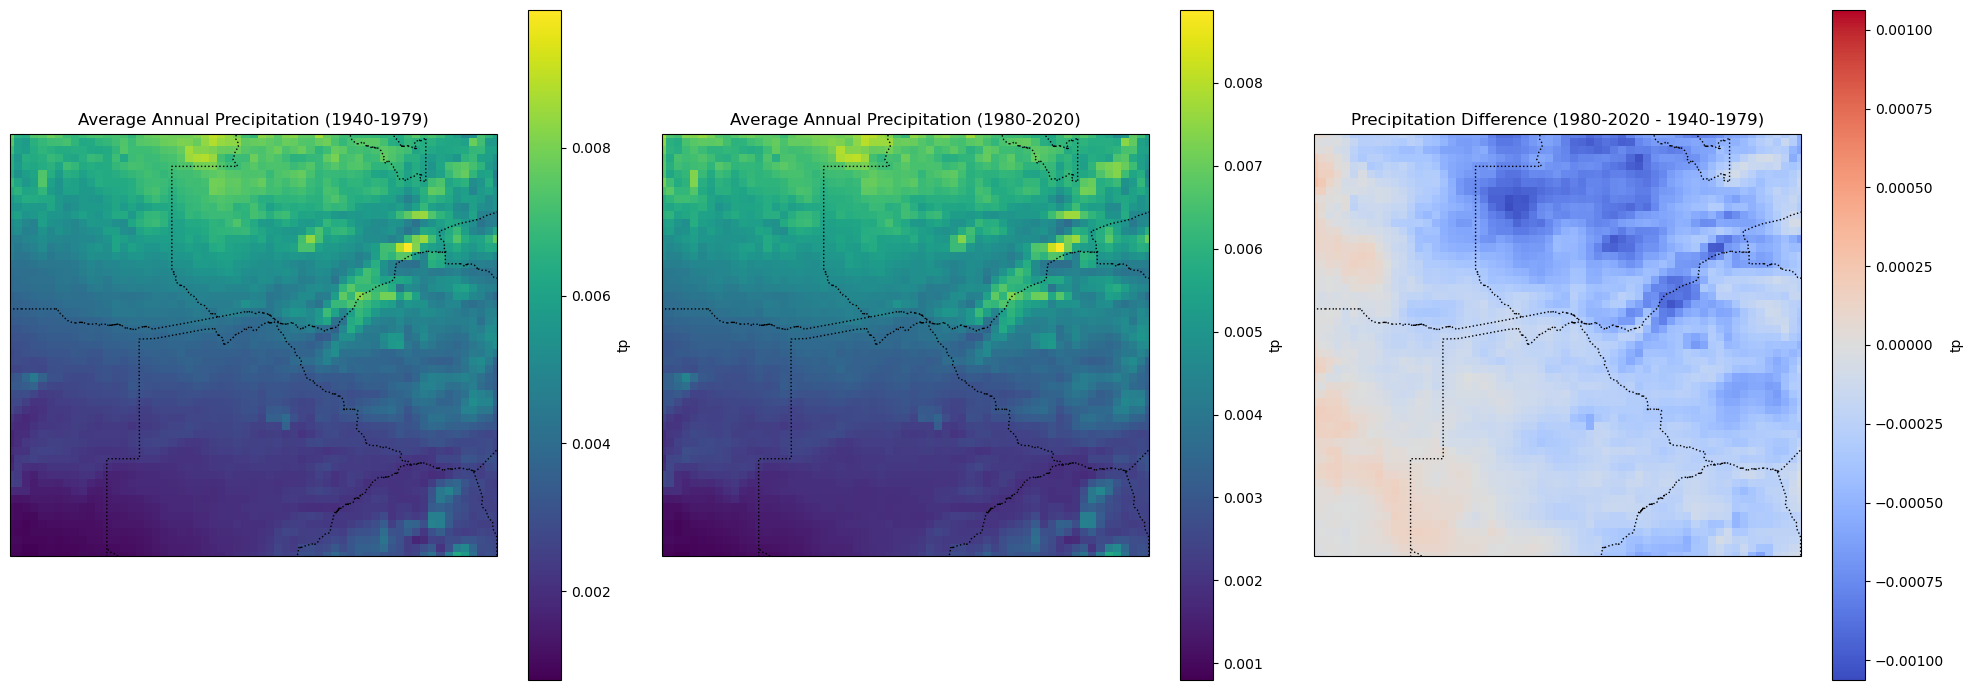

In [6]:
# 1. Extract data for the first 40 years (1940-1979)
data_first_40_years = o_f_precip_zambia.sel(date=slice('1940-01-01', '1979-12-31'))

# 2. Calculate annual average precipitation for the first period
annual_precip_first_40 = data_first_40_years.resample(date='YE').mean()

# 3. Extract data for the second 41 years (1980-2020)
data_second_41_years = o_f_precip_zambia.sel(date=slice('1980-01-01', '2020-12-31'))

# 4. Calculate annual average precipitation for the second period
annual_precip_second_41 = data_second_41_years.resample(date='YE').mean()

# 5. Calculate the difference (Second Period - First Period)
precip_difference = annual_precip_second_41['tp'].mean(dim='date') - annual_precip_first_40['tp'].mean(dim='date')

# 6. Plot the spatial maps of average annual precipitation for each period and the difference
fig, axes = plt.subplots(1, 3, figsize=(20, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the first 40 years
annual_precip_first_40['tp'].mean(dim='date').plot(ax=axes[0], cmap='viridis', transform=ccrs.PlateCarree())
axes[0].set_title('Average Annual Precipitation (1940-1979)')
axes[0].add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')  # Add country borders
axes[0].add_feature(cfeature.COASTLINE, edgecolor='black')  # Add coastline
axes[0].set_extent([17, 32, -25, -12], crs=ccrs.PlateCarree())

# Plot the second 41 years
annual_precip_second_41['tp'].mean(dim='date').plot(ax=axes[1], cmap='viridis', transform=ccrs.PlateCarree())
axes[1].set_title('Average Annual Precipitation (1980-2020)')
axes[1].add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')  # Add country borders
axes[1].add_feature(cfeature.COASTLINE, edgecolor='black')  # Add coastline
axes[1].set_extent([17, 32, -25, -12], crs=ccrs.PlateCarree())

# Plot the difference (1980-2020 minus 1940-1979)
precip_difference.plot(ax=axes[2], cmap='coolwarm', transform=ccrs.PlateCarree())
axes[2].set_title('Precipitation Difference (1980-2020 - 1940-1979)')
axes[2].add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')  # Add country borders
axes[2].add_feature(cfeature.COASTLINE, edgecolor='black')  # Add coastline
axes[2].set_extent([17, 32, -25, -12], crs=ccrs.PlateCarree())

# Show the plots
plt.tight_layout()
plt.show()

In [5]:
#Geopotential
mon_geopot_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_geopot_sa.nc')
mon_geopot_sa['date'] = pd.to_datetime(mon_geopot_sa['date'].values.astype(str), format='%Y%m%d')
mon_geopot_sa = mon_geopot_sa.sel(date=slice(None, '2020-12-01'))

mon_geopot_zambia = mon_geopot_sa.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
mon_geopot_zambia_mean = mon_geopot_zambia.mean(dim=('latitude', 'longitude'))

o_f_geopot_zambia_mean= mon_geopot_zambia_mean.sel(date=(mon_geopot_sa['date.month'] >= 10) | (mon_geopot_sa['date.month'] <= 2))
o_f_geopot_zambia_mean

<xarray.Dataset> Size: 11kB
Dimensions:         (date: 405, pressure_level: 1)
Coordinates:
    number          int64 8B ...
  * date            (date) datetime64[ns] 3kB 1940-01-01 ... 2020-12-01
  * pressure_level  (pressure_level) float64 8B 500.0
    expver          (date) <U4 6kB ...
Data variables:
    z               (date, pressure_level) float32 2kB 5.724e+04 ... 5.758e+04

In [6]:
#El Nino Data Prep
nino34 = mon_sst_anom['sst'].sel(
    longitude=slice(190, 240),  
    latitude=slice(5, -5)         
)

mean_nino34 = nino34.mean(dim=('latitude', 'longitude'))

o_f_nino = mean_nino34.sel(date=(mean_nino34['date.month'] >= 10) | (mean_nino34['date.month'] <= 2))

#IOD data
west_region_iod = mon_sst_anom['sst'].sel(
    longitude=slice(50, 70),  # Longitude range
    latitude=slice(10, -10)        # Latitude range
)

east_region_iod = mon_sst_anom['sst'].sel(
    longitude=slice(90, 110),  # Longitude range
    latitude=slice(10, -10)        # Latitude range
)

west_region_iod = west_region_iod.mean(dim=('latitude', 'longitude'))
east_region_iod = east_region_iod.mean(dim=('latitude', 'longitude'))

iod_index = west_region_iod - east_region_iod

o_f_iod = iod_index.sel(date=(iod_index['date.month'] >= 10) | (iod_index['date.month'] <= 2))

#step up ABFZ
abfz = mon_sst_anom['sst'].sel(
    longitude=(mon_sst_anom['sst'].longitude < 15) | (mon_sst_anom['sst'].longitude > 355),
    latitude=slice(-10, -20)  
)

mean_abfz = abfz.mean(dim=('latitude', 'longitude'))

o_f_abfz = mean_abfz.sel(date=(mean_abfz['date.month'] >= 10) | (mean_abfz['date.month'] <= 2))

#Set Up EMI
#box A: (165°E-140°W, 10°S-10°N)
box_a = mon_sst_anom['sst'].sel(
    longitude=slice(165, 220),  
    latitude=slice(10, -10)         
)
#Box B: (110°W-70°W, 15°S-5°N)
box_b = mon_sst_anom['sst'].sel(
    longitude=slice(250, 290),  
    latitude=slice(5, -15)         
)
#Box C: (125°E-145°E, 10°S-20°N)
box_c = mon_sst_anom['sst'].sel(
    longitude=slice(125, 145),  
    latitude=slice(20, -10)         
)

mean_box_a = box_a.mean(dim=('latitude', 'longitude'))

mean_box_b = box_b.mean(dim=('latitude', 'longitude'))

mean_box_c = box_c.mean(dim=('latitude', 'longitude'))

EMI = mean_box_a - (0.5 * mean_box_b) - (0.5 * mean_box_c)

o_f_EMI = EMI.sel(date=(EMI['date.month'] >= 10) | (EMI['date.month'] <= 2))

In [7]:
# I want to lag the sst by 1, 2, and 3 months to test in lagged sst predict precipitation
sept_jan_nino = mean_nino34.sel(date=(mean_nino34['date.month'] >= 9) | (mean_nino34['date.month'] <= 1))
sept_jan_iod = iod_index.sel(date=(iod_index['date.month'] >= 9) | (iod_index['date.month'] <= 1))
sept_jan_abfz = mean_abfz.sel(date=(mean_abfz['date.month'] >= 9) | (mean_abfz['date.month'] <= 1))
sept_jan_EMI = EMI.sel(date=(EMI['date.month'] >= 9) | (EMI['date.month'] <= 1))

sept_jan_nino = pd.DataFrame({"nino_lag_1": sept_jan_nino})
sept_jan_iod = pd.DataFrame({"iod_lag_1": sept_jan_iod})
sept_jan_abfz = pd.DataFrame({"abfz_lag_1": sept_jan_abfz})
sept_jan_EMI = pd.DataFrame({"EMI_lag_1": sept_jan_EMI})

aug_dec_nino = mean_nino34.sel(date=mean_nino34['date.month'].isin([8, 9, 10, 11, 12]))
aug_dec_iod = iod_index.sel(date=iod_index['date.month'].isin([8, 9, 10, 11, 12]))
aug_dec_abfz = mean_abfz.sel(date=mean_abfz['date.month'].isin([8, 9, 10, 11, 12]))
aug_dec_EMI = EMI.sel(date=EMI['date.month'].isin([8, 9, 10, 11, 12]))

aug_dec_nino = pd.DataFrame({"nino_lag_2": aug_dec_nino})
aug_dec_iod = pd.DataFrame({"iod_lag_2": aug_dec_iod})
aug_dec_abfz = pd.DataFrame({"abfz_lag_2": aug_dec_abfz})
aug_dec_EMI = pd.DataFrame({"EMI_lag_2": aug_dec_EMI})

july_nov_nino = mean_nino34.sel(date=mean_nino34['date.month'].isin([7, 8, 9, 10, 11]))
july_nov_iod = iod_index.sel(date=iod_index['date.month'].isin([7, 8, 9, 10, 11]))
july_nov_abfz = mean_abfz.sel(date=mean_abfz['date.month'].isin([7, 8, 9, 10, 11]))
july_nov_EMI = EMI.sel(date=EMI['date.month'].isin([7, 8, 9, 10, 11]))

july_nov_nino = pd.DataFrame({"nino_lag_3": july_nov_nino})
july_nov_iod = pd.DataFrame({"iod_lag_3": july_nov_iod})
july_nov_abfz = pd.DataFrame({"abfz_lag_3": july_nov_abfz})
july_nov_EMI = pd.DataFrame({"EMI_lag_3": july_nov_EMI})

o_f_geopot_zambia_mean['z'] = np.squeeze(o_f_geopot_zambia_mean['z'])

precip_df = pd.DataFrame({"precipitation": o_f_precip_zambia_mean['tp']})
iod_df = pd.DataFrame({"iod": o_f_iod})
nino_df = pd.DataFrame({"nino": o_f_nino})
abfz_df = pd.DataFrame({"abfz": o_f_abfz})
geopot_df = pd.DataFrame({"z": o_f_geopot_zambia_mean['z']})
emi_df = pd.DataFrame({"EMI": o_f_EMI})

# Combine predictors into a single DataFrame
all_data_df = pd.concat([precip_df, iod_df, nino_df, abfz_df, geopot_df, emi_df, \
                            sept_jan_nino, sept_jan_iod, sept_jan_abfz, sept_jan_EMI, \
                          aug_dec_nino, aug_dec_iod, aug_dec_abfz, aug_dec_EMI, \
                          july_nov_nino, july_nov_iod, july_nov_abfz, july_nov_EMI], axis=1)
all_data_df

,precipitation,iod,nino,abfz,z,EMI,nino_lag_1,iod_lag_1,abfz_lag_1,EMI_lag_1,nino_lag_2,iod_lag_2,abfz_lag_2,EMI_lag_2,nino_lag_3,iod_lag_3,abfz_lag_3,EMI_lag_3
0,0.006553,0.698060,0.852316,0.627607,57235.183594,0.197289,0.852316,0.698060,0.627607,0.197289,1.403491,0.258449,0.458452,1.007054,1.307361,-0.264717,-0.047782,0.905658
1,0.003822,0.186507,1.117755,0.515574,57395.207031,0.589123,0.971100,0.144534,-0.004244,0.542671,0.971100,0.144534,-0.004244,0.542671,1.403491,0.258449,0.458452,1.007054
2,0.000527,0.221616,0.492207,0.181209,57515.402344,0.445503,0.492207,0.221616,0.181209,0.445503,0.492207,0.221616,0.181209,0.445503,0.971100,0.144534,-0.004244,0.542671
3,0.002348,-0.241225,1.109326,-0.302088,57289.859375,0.270627,1.109326,-0.241225,-0.302088,0.270627,1.109326,-0.241225,-0.302088,0.270627,0.492207,0.221616,0.181209,0.445503
4,0.005576,-0.005607,1.245752,-0.067894,57442.257812,0.886929,1.245752,-0.005607,-0.067894,0.886929,1.245752,-0.005607,-0.067894,0.886929,1.109326,-0.241225,-0.302088,0.270627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,0.005803,0.309757,0.553871,1.466709,57711.050781,0.498436,0.553871,0.309757,1.466709,0.498436,-0.586089,-0.436052,0.837790,-0.278348,-0.231838,0.227412,0.997966,0.027706
401,0.007153,0.111391,0.379024,0.888973,57755.593750,0.458687,-0.752512,-0.423375,0.374008,-0.233736,-0.752512,-0.423375,0.374008,-0.233736,-0.586089,-0.436052,0.837790,-0.278348
402,0.000681,0.182486,-1.171242,0.266274,57729.285156,-0.491633,-1.171242,0.182486,0.266274,-0.491633,-1.171242,0.182486,0.266274,-0.491633,-0.752512,-0.423375,0.374008,-0.233736
403,0.003284,-0.110351,-1.251619,0.368881,57684.621094,-0.569854,-1.251619,-0.110351,0.368881,-0.569854,-1.251619,-0.110351,0.368881,-0.569854,-1.171242,0.182486,0.266274,-0.491633


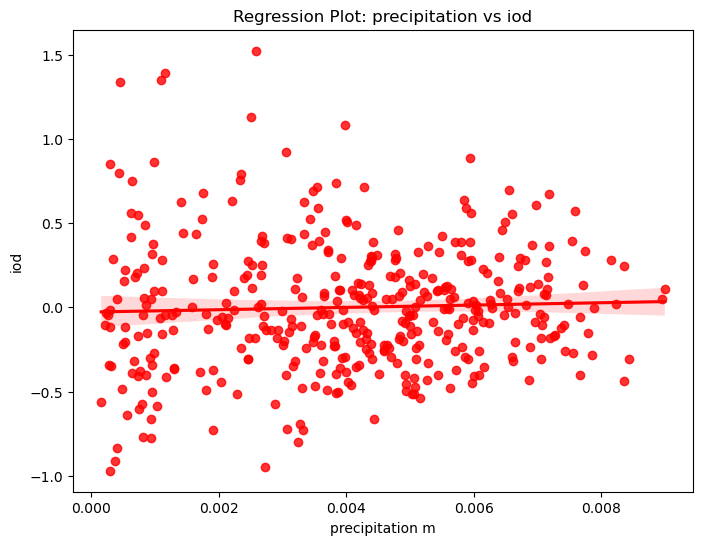

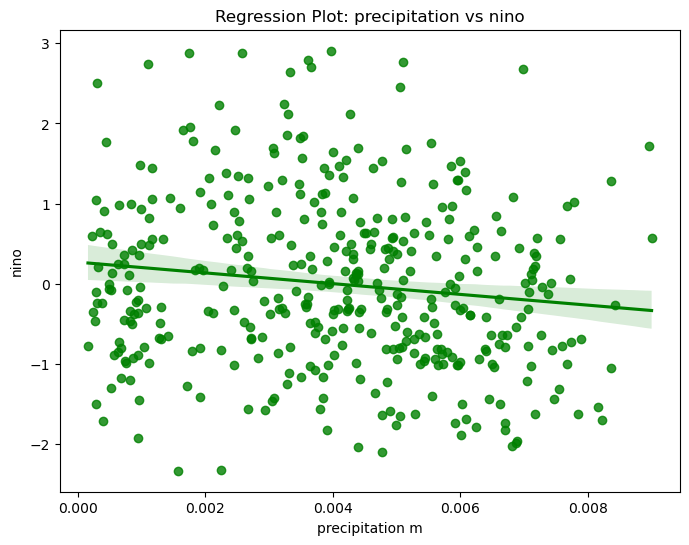

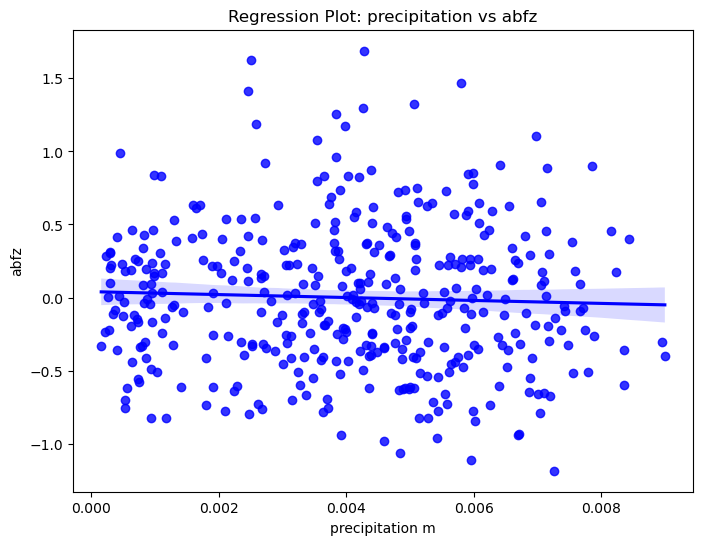

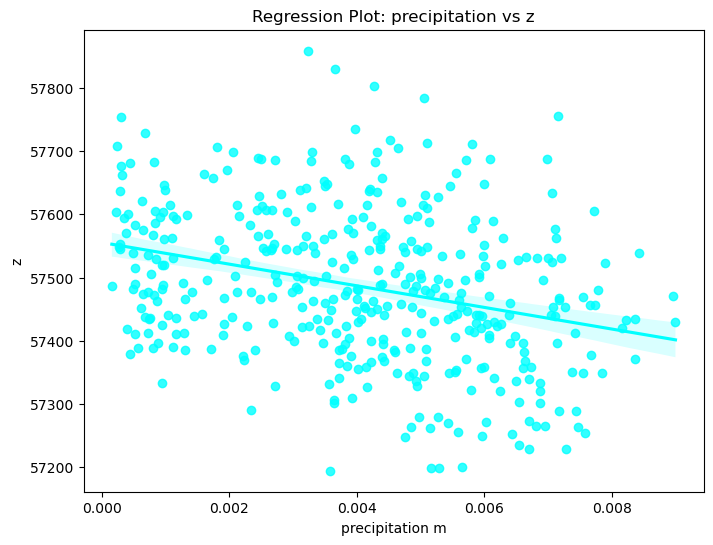

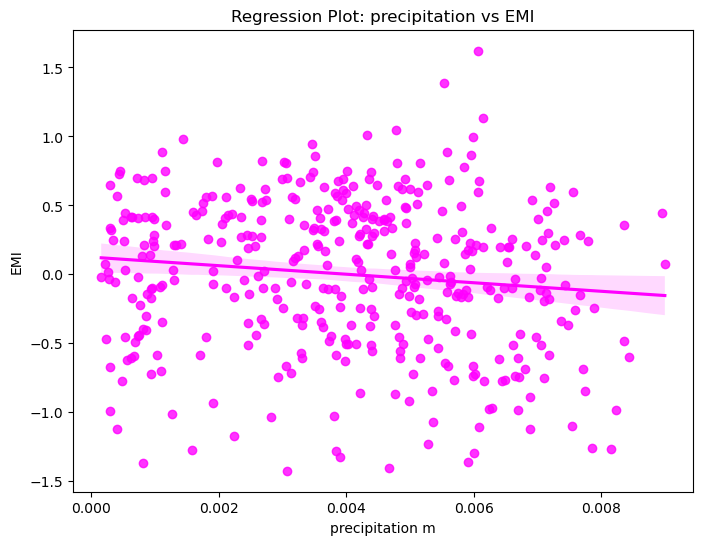

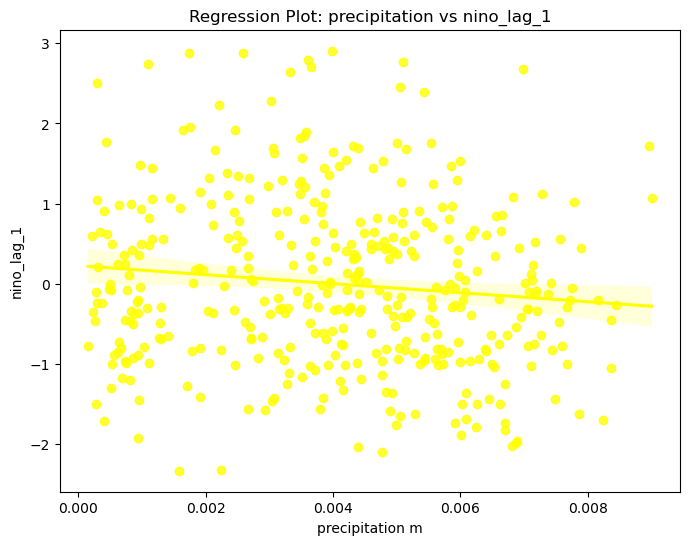

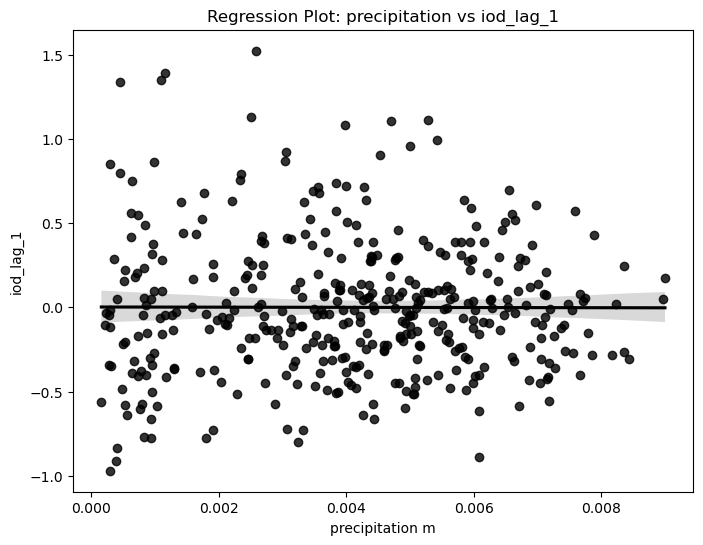

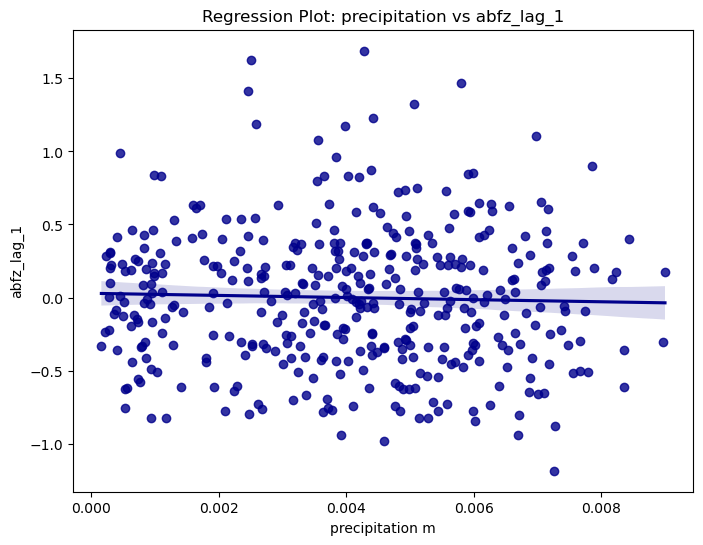

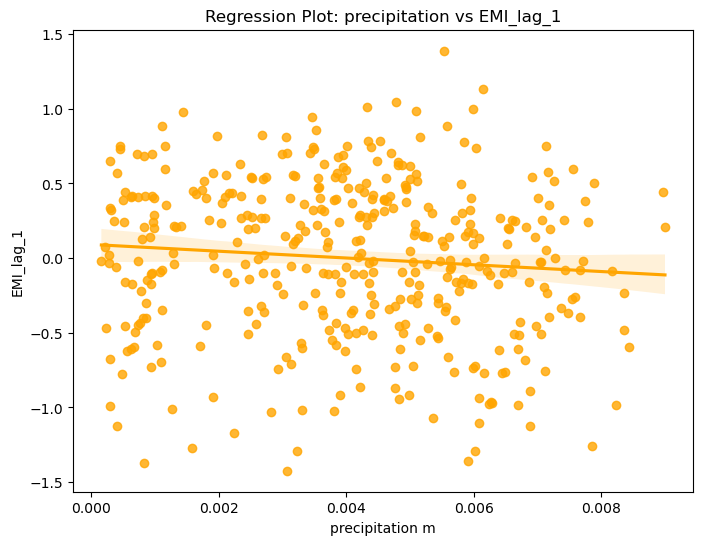

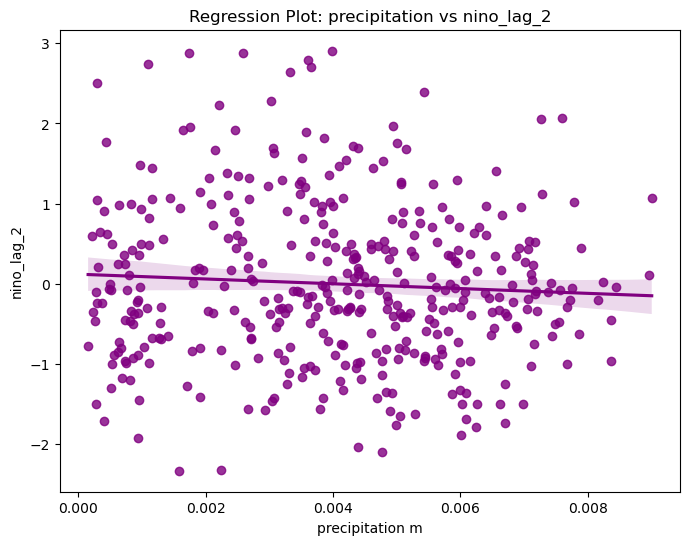

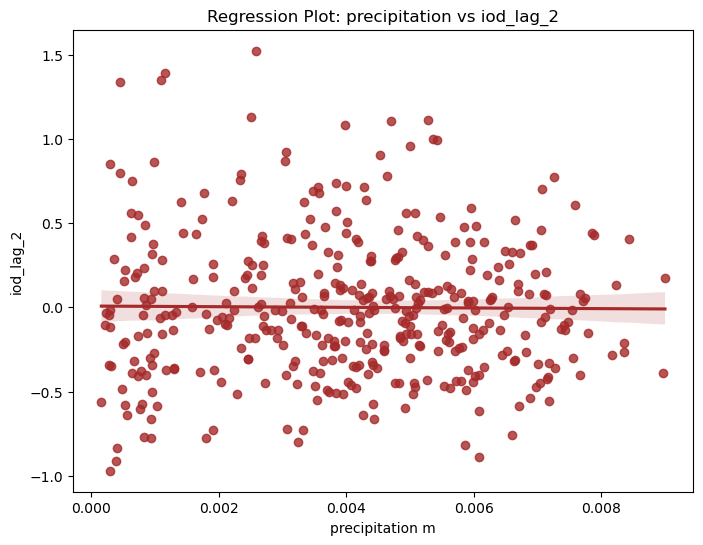

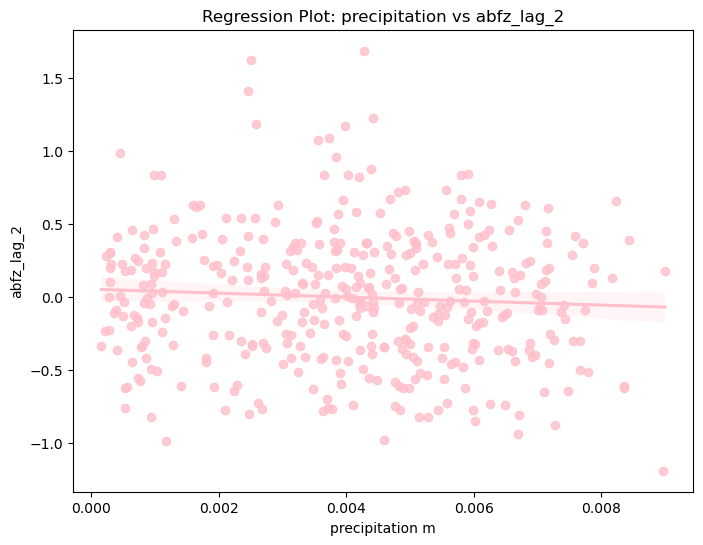

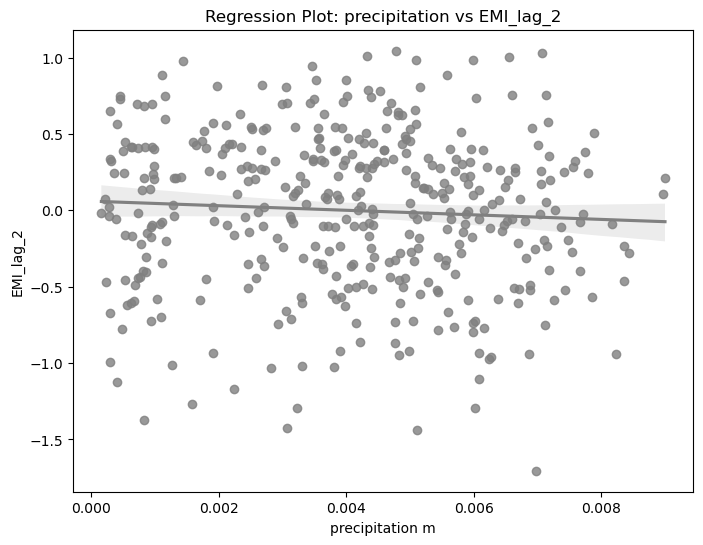

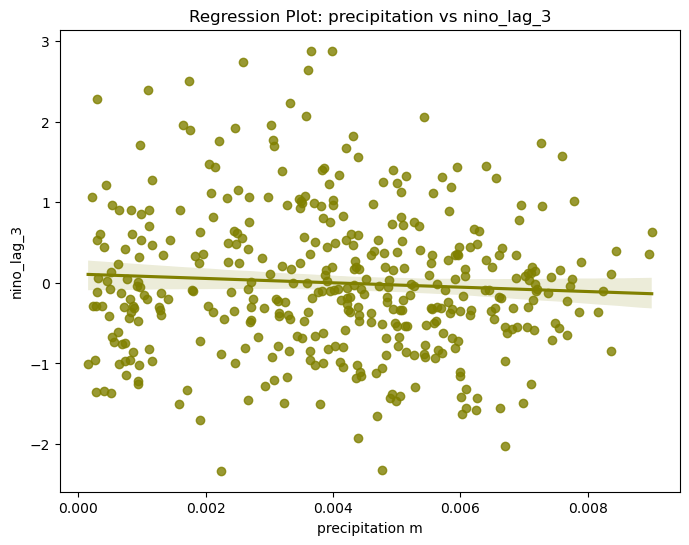

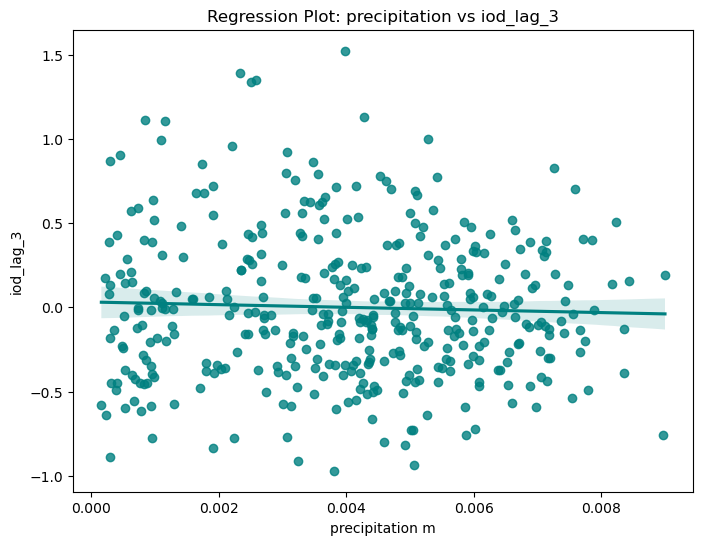

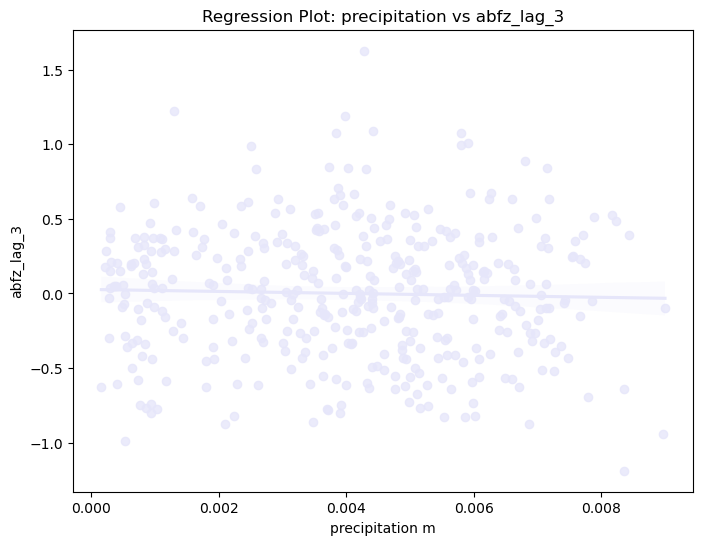

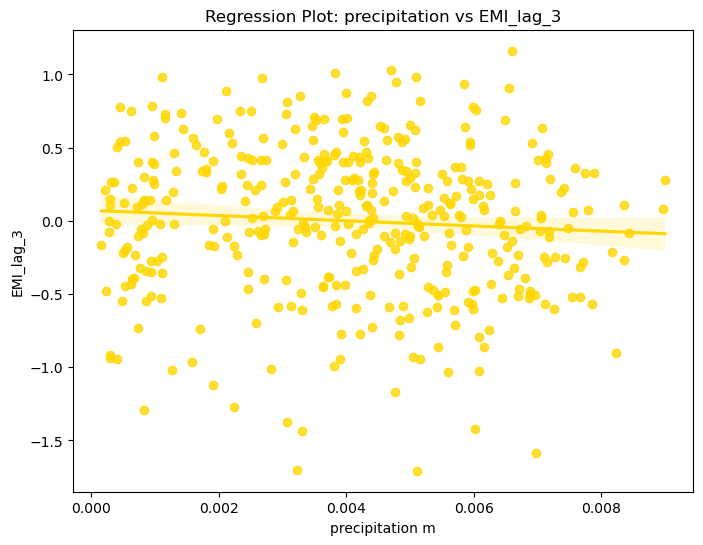

In [8]:
precip_col = all_data_df.columns[0]

colors = [
    'red',
    'green',
    'blue',
    'cyan',
    'magenta',
    'yellow',
    'black',
    'darkblue',
    'orange',
    'purple',
    'brown',
    'pink',
    'gray',
    'olive',
    'teal',
    'lavender',
    'gold'
]

# Create regression plots
for i, col in enumerate(all_data_df.columns[1:]):
    plt.figure(figsize=(8, 6))
    sns.regplot(x=precip_col, y=col, data=all_data_df, color=colors[i % len(colors)])
    plt.title(f'Regression Plot: {precip_col} vs {col}')
    plt.xlabel(f'{precip_col} m')
    plt.ylabel(col)
    plt.show()